# Simple SQL validator

We check for the validity of a SQL query using FSM (implemented through Python coroutines). To demonstrate the usefullness of Coroutines, we would only support following SELECT queries.

```
SELECT * from TABLE_NAME;
SELECT column, [...columns] from TABLE_NAME;
```

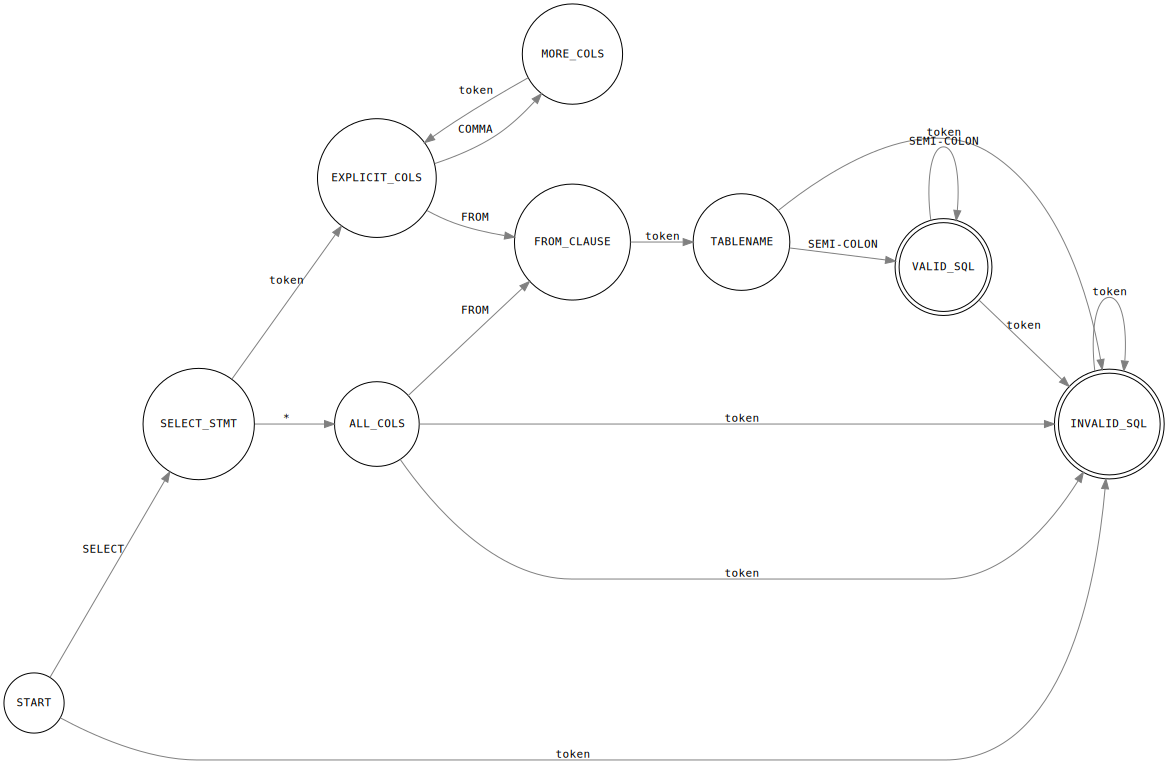

In [1]:
from graphviz import Source
with open("./sql.dot", "r") as f:
    gr = Source(f.read())
gr

In [2]:
def prime(fn):
    def wrapper(*args, **kwargs):
        v = fn(*args, **kwargs)
        v.send(None)
        return v
    return wrapper

In [3]:
class SQLValidatorFSM:
    def __init__(self):
        self.current_state = None
        
        self.state_init = self._create_state_init()
        self.state_select_stmt = self._create_state_select_stmt()
        self.state_all_cols = self._create_state_all_cols()
        self.state_explicit_cols = self._create_state_explicit_cols()
        self.state_from_clause = self._create_state_from_clause()
        self.state_more_cols = self._create_state_more_cols()
        self.state_tablename = self._create_state_tablename()
        self.state_valid_sql = self._create_state_valid_sql()
        self.state_invalid_sql = self._create_state_invalid_sql()
        
        self.current_state = self.state_init
        
    def send(self, token):
        self.current_state.send(token)
        
    def is_valid(self):
        return self.current_state == self.state_valid_sql

    @prime
    def _create_state_init(self):
        while True:
            token = yield
            if token == "select":
                self.current_state = self.state_select_stmt
            else:
                self.current_state = self.state_invalid_sql

    @prime
    def _create_state_select_stmt(self):
        while True:
            token = yield
            if token == "*":
                self.current_state = self.state_all_cols
            else:
                self.current_state = self.state_explicit_cols
          
    @prime
    def _create_state_all_cols(self):
        while True:
            token = yield
            if token == 'from':
                self.current_state = self.state_from_clause
            else:
                self.current_state = self.state_invalid_sql

    @prime
    def _create_state_explicit_cols(self):
        while True:
            token = yield
            if token == 'from':
                self.current_state = self.state_from_clause
            elif token == ',':
                self.current_state = self.state_more_cols
            else:
                self.current_state = self.state_invalid_sql
           
    @prime
    def _create_state_from_clause(self):
        while True:
            token = yield
            if token.isalnum():
                self.current_state = self.state_tablename
            else:
                self.current_state = self.state_invalid_sql
           
    @prime
    def _create_state_more_cols(self):
        while True:
            token = yield
            if token.isalnum():
                self.current_state = self.state_explicit_cols
            else:
                self.current_state = self.state_invalid_sql
             
    @prime
    def _create_state_tablename(self):
        while True:
            token = yield
            if token == ";":
                self.current_state = self.state_valid_sql
            else:
                self.current_state = self.state_invalid_sql
            
    @prime
    def _create_state_valid_sql(self):
        while True:
            token = yield
            if token == ";":
                self.current_state = self.state_valid_sql
            else:
                self.current_state = self.state_invalid_sql
           
    @prime
    def _create_state_invalid_sql(self):
        while True:
            token = yield
            self.current_state = self.state_invalid_sql

In [4]:
def is_sql_valid(query):
    validator = SQLValidatorFSM()
    for token in query.split():
        validator.send(token)
    return validator.is_valid()

In [5]:
is_sql_valid("select * from users ;")

True

In [6]:
is_sql_valid("select id from users ;")

True

In [7]:
is_sql_valid("select id , name from users ;")

True

In [8]:
is_sql_valid("update id;")

False

In [9]:
is_sql_valid("select a = 1 from users ;")

False